# UMAP Segmentation for the Fluorscent Imaging

For image segmentation is a computational heavy task. Recommend to use GPU version of UMAP for fast output.

Key package dependency:
- [cuml](https://docs.rapids.ai/install)
- [umap](https://umap-learn.readthedocs.io/en/latest/index.html)
- [numba](https://numba.pydata.org/numba-doc/latest/index.html)
- [dask-cuda](https://docs.rapids.ai/api)

In [1]:
%%script false --no-raise-error
# The dependency can be size up to >4GB. This step may take very long time, particular for libraft-distance, recommend to use mamba for quicker install
!mamba install -y -c rapidsai -c conda-forge -c nvidia cuml cudatoolkit numba umap-learn dask-cuda aicsimageio pyclesperanto-prototype ocl-icd-system
!mamba install -y -c simpleitk simpleitk

In [2]:
%%script false --no-raise-error
%pip install aicspylibczi

In [103]:
import os
from aicsimageio import AICSImage
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import dask
import dask.array as da
import dask.array.image
from dask.distributed import Client, progress, Scheduler, Worker, Nanny, SpecCluster
from dask_cuda import CUDAWorker
from dask_cuda.worker_spec import worker_spec
from dask_cuda.initialize import initialize
import psutil
import multiprocessing

from pprint import pprint
from xml.etree.ElementTree import ElementTree, Element
import json
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
import umap

import cuml
import cupy as cp
import pyclesperanto_prototype as cle

import numpy as np
from sklearn.cluster import MiniBatchKMeans

import SimpleITK as sitk
import pandas as pd

In [4]:
print(cle.available_device_names())

['NVIDIA GeForce GTX 1080 Ti', 'NVIDIA GeForce GTX 1080 Ti', 'cupy backend (experimental)']


## Prepare Dask Cluster
We only have one GPU on the workstation, to speed up the CPU side process it is advise to setup heterogenous cluster.

In [5]:
# gather device info
cpu_count = multiprocessing.cpu_count()
memory_count = psutil.virtual_memory().total
print("CPU count:", cpu_count)
print("System memory:",round(memory_count/(1024*1024*1024),2), "GB")

CPU count: 20
System memory: 251.8 GB


In [6]:
# Note that scale time GPU per worker should never exceed length of specified CUDA_VISIBLE_DEVICES
specs = {
    "cpu":{
        "scale":3,
        "resources":{
        }
    },
    "gpu":{
        "scale":2,
        "CUDA_VISIBLE_DEVICES": [2,3],
        "resources":{
            "GPU": 1
        }
    }
}

assert specs["gpu"]["scale"]*specs["gpu"]["resources"]["GPU"] <= len(specs["gpu"]["CUDA_VISIBLE_DEVICES"]), "Number of gpu workers (scale) times GPU per worker should not exceed length of CUDA_VISIBLE_DEVICES"

worker_count = 0
for v in specs.values():
    worker_count += v["scale"]

nthreads = cpu_count//worker_count
memory_limit = int(memory_count*0.9)//worker_count # set to use 90% of the system memory to avoid crashing

print("number of workers:", worker_count)
print("threads per worker:", nthreads)
print("memory limit per worker:", round(memory_limit/(1024*1024*1024),2), "GB")
print("GPU workers:", specs["gpu"]["scale"])
print("GPU per worker:", specs["gpu"]["resources"]["GPU"])

number of workers: 5
threads per worker: 4
memory limit per worker: 45.32 GB
GPU workers: 2
GPU per worker: 1


In [7]:
workers = {}

for k, v in specs.items():
    for i in range(v["scale"]):
        if "CUDA_VISIBLE_DEVICES" in v.keys():
            CUDA_VISIBLE_DEVICES = v["CUDA_VISIBLE_DEVICES"]
            gpu_per_worker = v["resources"]["GPU"]
            assert gpu_per_worker == 1, "gpu per worker need to be 1 for dask cuda"
            ws = worker_spec(
                threads_per_worker=nthreads, 
                CUDA_VISIBLE_DEVICES=CUDA_VISIBLE_DEVICES[gpu_per_worker*i:gpu_per_worker*(i+1)]
                )
            workers["{}-{}".format(k,i)] = ws[v["CUDA_VISIBLE_DEVICES"][i]]
            workers["{}-{}".format(k,i)]["options"]["resources"]={"GPU":v["resources"]["GPU"]}
            workers["{}-{}".format(k,i)]["options"]["memory_limit"]=memory_limit
        else:
            workers["{}-{}".format(k,i)] = {
                "cls":Nanny,
                "options":{
                    "nthreads": nthreads,
                    "memory_limit": memory_limit
                    }
             }     
            
workers

2023-04-18 15:12:34,249 - distributed.comm.ucx - WARNING - A CUDA context for device 2 (b'GPU-068ed0e2-4d1b-d573-1361-970900927886') already exists on process ID 21555. This is often the result of a CUDA-enabled library calling a CUDA runtime function before Dask-CUDA can spawn worker processes. Please make sure any such function calls don't happen at import time or in the global scope of a program.


{'cpu-0': {'cls': distributed.nanny.Nanny,
  'options': {'nthreads': 4, 'memory_limit': 48666354647}},
 'cpu-1': {'cls': distributed.nanny.Nanny,
  'options': {'nthreads': 4, 'memory_limit': 48666354647}},
 'cpu-2': {'cls': distributed.nanny.Nanny,
  'options': {'nthreads': 4, 'memory_limit': 48666354647}},
 'gpu-0': {'cls': distributed.nanny.Nanny,
  'options': {'env': {'CUDA_VISIBLE_DEVICES': '2'},
   'interface': None,
   'protocol': None,
   'nthreads': 4,
   'data': dict,
   'dashboard_address': ':8787',
   'plugins': [<dask_cuda.utils.CPUAffinity at 0x7fba9ede7280>],
   'silence_logs': True,
   'memory_limit': 48666354647,
   'preload': 'dask_cuda.initialize',
   'preload_argv': '--create-cuda-context',
   'resources': {'GPU': 1}}},
 'gpu-1': {'cls': distributed.nanny.Nanny,
  'options': {'env': {'CUDA_VISIBLE_DEVICES': '3'},
   'interface': None,
   'protocol': None,
   'nthreads': 4,
   'data': dict,
   'dashboard_address': ':8787',
   'plugins': [<dask_cuda.utils.CPUAffinity a

In [8]:
scheduler = {'cls': Scheduler, 'options': {"dashboard_address": ':8787'}}
cluster = SpecCluster(scheduler=scheduler, workers=workers)
client = Client(cluster)
client

2023-04-18 15:12:37,754 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-04-18 15:12:37,789 - distributed.scheduler - INFO - State start
2023-04-18 15:12:37,793 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.136.8.105:42195
2023-04-18 15:12:37,793 - distributed.scheduler - INFO -   dashboard at:  http://10.136.8.105:8787/status
2023-04-18 15:12:37,813 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.136.8.105:45967'
2023-04-18 15:12:37,856 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.136.8.105:36800'
2023-04-18 15:12:37,861 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.136.8.105:43781'
2023-04-18 15:12:37,864 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.136.8.105:40986'
2023-04-18 15:12:37,868 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.136.8.105:39755'
2023-04-18 15:12:41,965 -

<Client: 'tcp://10.136.8.105:42195' processes=5 threads=20, memory=226.62 GiB>

## Data Loading

For effective data loading, use [aicsimageio](https://github.com/AllenCellModeling/aicsimageio)

In [9]:
# idrive
# IMAGE_DATA = "/mnt/Imaging/Group Fritzsche/Jacky/myocardial cells/For sharing analysis/no097_FR_D30_Q2_lv2_CD31-AF555_PDGFRa-AF647_WGA-AF488.czi"

# kirpc541
# IMAGE_DATA = "/home/jackyko/Jacky/data/mycardial_cells/no097_FR_D30_Q2_lv2_CD31-AF555_PDGFRa-AF647_WGA-AF488.czi"

# bmrc
IMAGE_DATA = "/users/kir-fritzsche/oyk357/archive/myocardial_data/no097_FR_D30_Q2_lv2_CD31-AF555_PDGFRa-AF647_WGA-AF488.czi"

In [10]:
img = AICSImage(IMAGE_DATA)
print(img.dims.order)  # T, C, Z, Y, X, (S optional)
img.dask_data

2023-04-18 15:12:55,596 - distributed.core - INFO - Event loop was unresponsive in Nanny for 3.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2023-04-18 15:12:55,612 - distributed.core - INFO - Event loop was unresponsive in Nanny for 3.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


TCZYX


dask.array<transpose, shape=(1, 4, 1, 16720, 16749), dtype=uint16, chunksize=(1, 4, 1, 4096, 4096), chunktype=numpy.ndarray>

In [11]:
img.scenes

('ScanRegion0', 'ScanRegion1')

In [12]:
img.set_scene("ScanRegion0")

For faster display, we load the image with subsampling

In [13]:
SCALE = 10

In [14]:
img_dask_sub = img.dask_data[:,:,::SCALE,::SCALE,::SCALE]
img_dask_sub

dask.array<getitem, shape=(1, 4, 1, 1672, 1675), dtype=uint16, chunksize=(1, 4, 1, 410, 410), chunktype=numpy.ndarray>

For quicker subsequent performance we recommended to load data to ram at this point

In [15]:
img_dask_sub = img_dask_sub.persist()
img_dask_sub

dask.array<getitem, shape=(1, 4, 1, 1672, 1675), dtype=uint16, chunksize=(1, 4, 1, 410, 410), chunktype=numpy.ndarray>

## Channel Metadata

In [16]:
def etree_to_dict(t):
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k: v[0] if len(v) == 1 else v
                     for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v)
                        for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
                d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d

In [17]:
META = img.metadata

In [18]:
d = etree_to_dict(META)

pprint(d)

{'ImageDocument': {'Metadata': {'AttachmentInfos': {'AttachmentInfo': {'@Id': 'Label:1',
                                                                       'Label': {'Barcodes': {'Barcode': {'@Id': 'Barcode:1',
                                                                                                          'Content': None,
                                                                                                          'Type': None}},
                                                                                 'OCRs': {'OCR': {'@Id': 'OCR:1',
                                                                                                  'Content': None}}},
                                                                       'Profile': {'IsProfileModified': 'True',
                                                                                   'ProfileName': 'REF_FL '
                                                                                        

In [19]:
# image information metadata
channel_info = d["ImageDocument"]["Metadata"]["Information"]["Image"]['Dimensions']['Channels']['Channel']
pprint(channel_info)


[{'@Id': 'Channel:0',
  '@Name': 'DAPI',
  'AcquisitionMode': 'WideField',
  'Color': '#FF00A0FF',
  'ComponentBitCount': '16',
  'ContrastMethod': 'Fluorescence',
  'CustomAttributes': {'MM.TotalMagnification': '20'},
  'DetectionWavelength': None,
  'DetectorSettings': {'Binning': '1,1',
                       'Detector': {'@Id': 'Detector:ORCA Flash'}},
  'DyeDatabaseId': '66071726-cbd4-4c41-b371-0a6eee4ae9c5',
  'DyeId': 'McNamara-Boswell-0434',
  'EmissionWavelength': '465',
  'ExcitationWavelength': '353',
  'ExposureTime': '5303600',
  'FilterSetRef': {'@Id': 'FilterSet:1'},
  'Fluor': 'DAPI',
  'IlluminationType': 'Epifluorescence',
  'IlluminationWavelength': {'Ranges': '370-400', 'SinglePeak': '385'},
  'LightSourcesSettings': {'LightSourceSettings': {'Intensity': '5.00 %',
                                                   'LightSource': {'@Id': 'LightSource:1'}}},
  'PixelType': 'Gray16'},
 {'@Id': 'Channel:1',
  '@Name': 'AF555',
  'AcquisitionMode': 'WideField',
  'Color'

In [74]:
# dictionary for the cell labels
CELL_LABELS = {
    "DAPI": "Nucleus",
    "AF555": "Endothelial (CD31)",
    "AF647": "Fibroblasts (PDGFRa)",
    "AF488": "Cell Border Fibrosis (WGA)"
}

## Display the Image

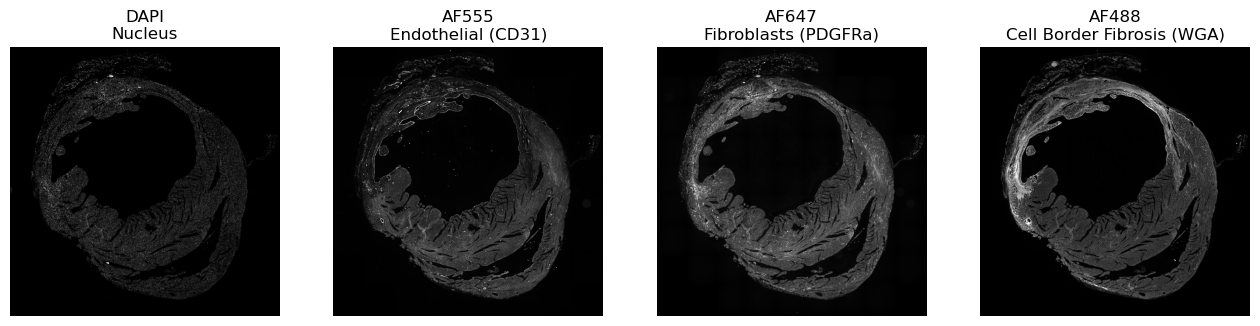

In [76]:
fig, axs = plt.subplots(1,4,figsize=(16,10))

for i in range(4):
    ax = axs[i]
    ax.set_axis_off()
    img_ch = img_dask_sub[0,i,0,]
    lp = da.percentile(img_ch.ravel(),0.5)
    up = da.percentile(img_ch.ravel(),99.5)
    ax.imshow(img_ch,cmap="gray",vmin=lp,vmax=up)
    ax.set_title("{}\n{}".format(channel_info[i]['@Name'],CELL_LABELS[channel_info[i]['@Name']]))

## Gaussian Blur to the Image

In [21]:
def cle_gaussian_blur(image):
    blurred_device = cle.gaussian_blur(image, sigma_x=2, sigma_y=2)
    blurred_host = da.from_array(cle.pull(blurred_device))

    # memory clean up
    blurred_device.data.release()

    # variable with automatically removed at the end of function scope
    return blurred_host

In [22]:
img_dask_sub[0,i,0,]

dask.array<getitem, shape=(1672, 1675), dtype=uint16, chunksize=(410, 410), chunktype=numpy.ndarray>

In [23]:
futures = []
for i in range(4):
    future = dask.delayed(cle_gaussian_blur)(img_dask_sub[0,i,0,])
    futures.append(future)

In [24]:
# specify the worker for the compute process
with dask.annotate(resources={'GPU': 1}):
    res = dask.compute(*futures)

2023-04-18 15:13:24,839 - distributed.core - INFO - Event loop was unresponsive in Worker for 4.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


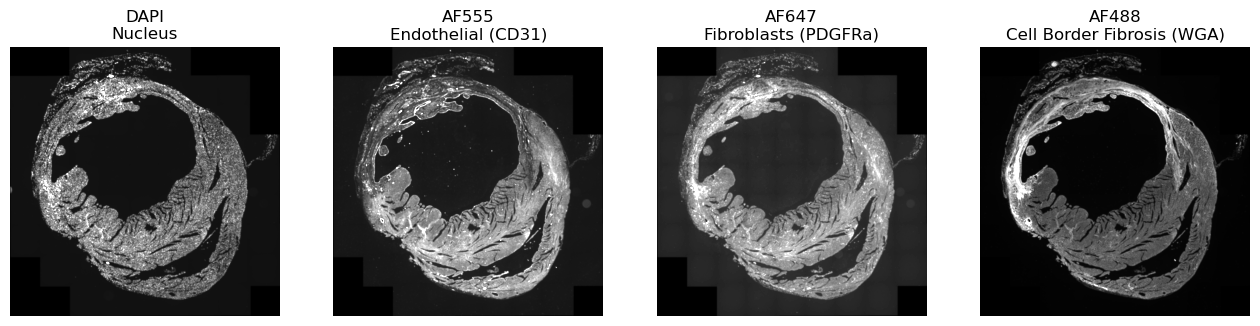

In [77]:
fig, axs = plt.subplots(1,4,figsize=(16,10))

for i in range(4):
    ax = axs[i]
    ax.set_axis_off()
    img_ch = res[i]
    lp = da.percentile(img_ch.ravel(),0.5)
    up = da.percentile(img_ch.ravel(),99.5)
    ax.imshow(img_ch,cmap="gray",vmin=lp,vmax=up)
    ax.set_title("{}\n{}".format(channel_info[i]['@Name'],CELL_LABELS[channel_info[i]['@Name']]))

## Background Detection

In [26]:
img_dask_sub_blur = da.stack(res)
img_dask_sub_blur

dask.array<stack, shape=(4, 1672, 1675), dtype=float32, chunksize=(1, 1672, 1675), chunktype=numpy.ndarray>

In [27]:
input = img_dask_sub_blur.T.reshape(-1,4)/255.0

/users/kir-fritzsche/oyk357/devel/conda/ivybridge/envs/myocardial/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=3)

In [54]:
%%time
kmeans = MiniBatchKMeans(3)
kmeans.fit(input)

/users/kir-fritzsche/oyk357/devel/conda/ivybridge/envs/myocardial/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 29.4 s, sys: 525 ms, total: 29.9 s
Wall time: 2 s


MiniBatchKMeans(n_clusters=3)

In [56]:
mask = da.from_array(kmeans.labels_.reshape(img_dask_sub.T.shape[0:2]))
mask = mask>=1

In [118]:
statFilter = sitk.LabelShapeStatisticsImageFilter()
statFilter.ComputeOrientedBoundingBoxOn()
statFilter.Execute(sitk.GetImageFromArray(mask.astype(np.uint8)))

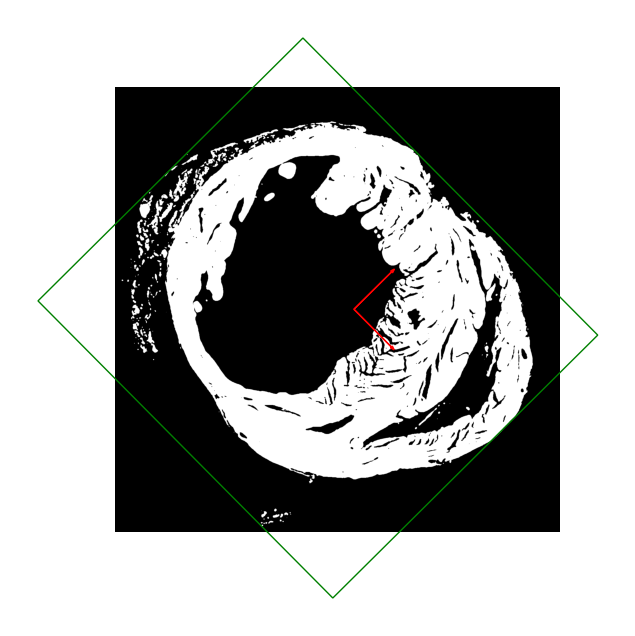

In [137]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(mask,cmap='gray')
ax.set_axis_off()
ARROW_SCALE = 200
ax.arrow(
    statFilter.GetCentroid(1)[0], 
    statFilter.GetCentroid(1)[1], 
    statFilter.GetOrientedBoundingBoxDirection(1)[0]*ARROW_SCALE, 
    statFilter.GetOrientedBoundingBoxDirection(1)[1]*ARROW_SCALE, 
    head_width=10, head_length=15, fc='r', ec='r')
ax.arrow(
    statFilter.GetCentroid(1)[0], 
    statFilter.GetCentroid(1)[1], 
    statFilter.GetOrientedBoundingBoxDirection(1)[2]*ARROW_SCALE, 
    statFilter.GetOrientedBoundingBoxDirection(1)[3]*ARROW_SCALE, 
    head_width=10, head_length=15, fc='r', ec='r')
# Create an oriented bbox patch
vertices = np.asarray(statFilter.GetOrientedBoundingBoxVertices(1)).reshape(-1,2)
vertices[2:4] = vertices[2:4][::-1]

poly = patches.Polygon(vertices[0:],linewidth=1, edgecolor='g', facecolor='none')

# # Add the patch to the Axes
ax.add_patch(poly)

Mask out the original image for better input in UMAP

In [30]:
img_dask_sub_masked = img_dask_sub

for i in range(4):
    img_dask_sub_masked[0,i,0,].T[mask==0] = 0

img_dask_sub_masked = img_dask_sub_masked.persist()

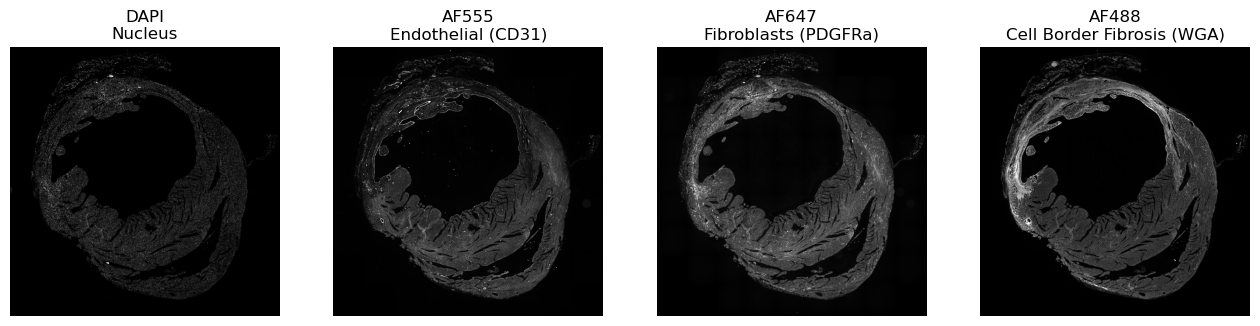

In [78]:
fig, axs = plt.subplots(1,4,figsize=(16,10))

for i in range(4):
    ax = axs[i]
    ax.set_axis_off()
    img_ch = img_dask_sub_masked[0,i,0,]
    lp = da.percentile(img_ch.ravel(),0.5)
    up = da.percentile(img_ch.ravel(),99.5)
    ax.imshow(img_ch,cmap="gray",vmin=lp,vmax=up)
    ax.set_title("{}\n{}".format(channel_info[i]['@Name'],CELL_LABELS[channel_info[i]['@Name']]))

## Pixel Intensity Clustering for Region Identification

Convert the multi channel image to vector form before applying K mean clustering

### Normalize Input Data

In [70]:
%%time
input = img_dask_sub_masked[0,1:4,0,].T
input = input.reshape(-1,input.shape[-1])/255.0
input

(1675, 1672, 3)
CPU times: user 2.38 ms, sys: 5.35 ms, total: 7.73 ms
Wall time: 7.38 ms


dask.array<truediv, shape=(2800600, 3), dtype=float64, chunksize=(142120, 3), chunktype=numpy.ndarray>

In [71]:
scaled_input_data = da.from_array(StandardScaler().fit_transform(input))
scaled_input_data

/users/kir-fritzsche/oyk357/devel/conda/ivybridge/envs/myocardial/lib/python3.10/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


dask.array<array, shape=(2800600, 3), dtype=float64, chunksize=(2800600, 3), chunktype=numpy.ndarray>

In [72]:
kmeans_multi = MiniBatchKMeans(4)
kmeans_multi.fit(scaled_input_data)
new_colors = kmeans_multi.cluster_centers_[kmeans_multi.predict(scaled_input_data)]

/users/kir-fritzsche/oyk357/devel/conda/ivybridge/envs/myocardial/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2023-04-18 16:14:52,642 - distributed.utils_perf - INFO - full garbage collection released 85.46 MiB from 237658 reference cycles (threshold: 9.54 MiB)


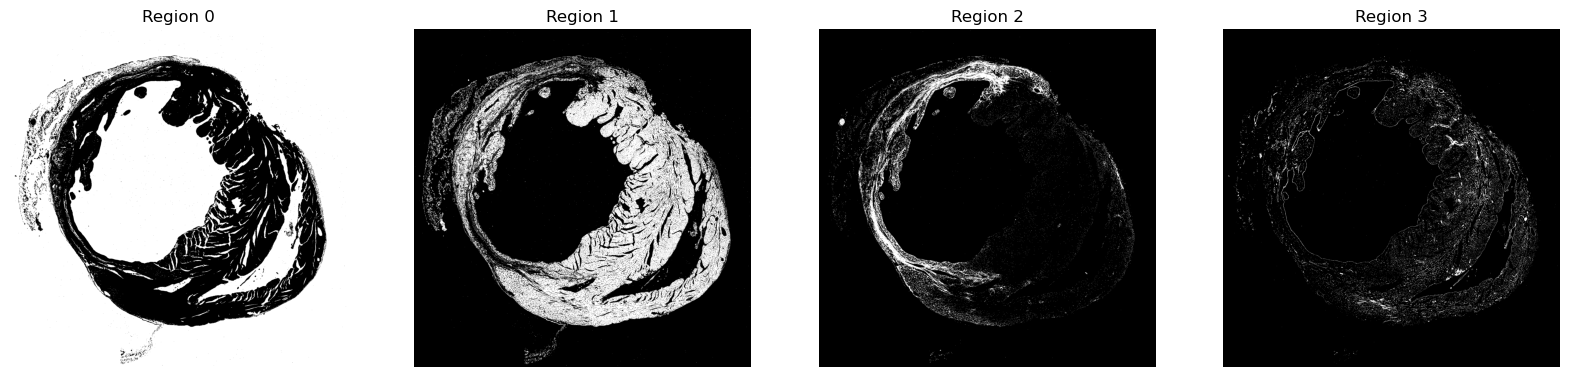

In [73]:
# plot_pixels(input, colors=new_colors,title="Reduced color space: 3 colors")
fig, axs = plt.subplots(1,4,figsize=(20,5))
labels = kmeans_multi.labels_.reshape(img_dask_sub_masked[0,:,0,].T.shape[0:2])
for i,ax in enumerate(axs):
    ax.set_title("Region {}".format(i))
    ax.imshow(labels==i,cmap="gray")
    ax.set_axis_off()

## Label Statistics

In [85]:
seg_sitk = sitk.GetImageFromArray(labels)

In [90]:
statFilter = sitk.LabelShapeStatisticsImageFilter()
statFilter.Execute(seg_sitk)

stat_dict = {
    "label": [],
    "pixels":[],
    "obb_dir_0":[],
    "obb_dir_1":[],
    }
for i in statFilter.GetLabels():
    stat_dict["label"].append(i)
    stat_dict["pixels"].append(statFilter.GetNumberOfPixels(i))
    stat_dict["obb_dir_0"].append(statFilter.GetOrientedBoundingBoxDirection(i)[0])
    stat_dict["obb_dir_1"].append(statFilter.GetOrientedBoundingBoxDirection(i)[1])

stat_df = pd.DataFrame.from_dict(stat_dict)
stat_df

,label,pixels,obb_dir_0,obb_dir_1
0,1,595272,0.729005,-0.684508
1,2,122554,0.958147,0.286276
2,3,82942,0.642137,-0.766590


In [ ]:
fig, axs = plt.subplots(1,4,figsize=(20,5))
labels = kmeans_multi.labels_.reshape(img_dask_sub_masked[0,:,0,].T.shape[0:2])
for i,ax in enumerate(axs):
    ax.set_title("Region {}".format(i))
    ax.imshow(labels==i,cmap="gray")
    ax.set_axis_off()

## Cell Counting